In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLVF71E/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLVF71E/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


**Resize -- Augument -- Normalize**

In [3]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [4]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [6]:

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [7]:
#apply the transformation to the datapoints 
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

If we execute print(train_dataset), we will notice that the image is in the shape of 128x128x3 of tf.float32 while the image mask is in the shape of 128x128x1 with the data type of tf.uint8.

In [8]:
print(train_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


data pipelines for training, validation, and testing 

cache - This operation caches the elements of the dataset in memory after they are loaded from storage. This can speed up data loading during training, especially if your dataset fits in memory.

suffle - it will take 1000 sample and suffle in memory  

batch - from that 1000 sample it will take 64 sample choosing randomly

repeat - this process will repeat how many time you will need means indefenitly so that at each epoch model will see different batches of sample

skip - this means skip 3000 sample and take the sample after 3000

take - take 669 sample that are remaining 

prefetch - after taking 64 sample you have to keep it ready for next round so again prepare for the next epochs while the model is processing the data

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


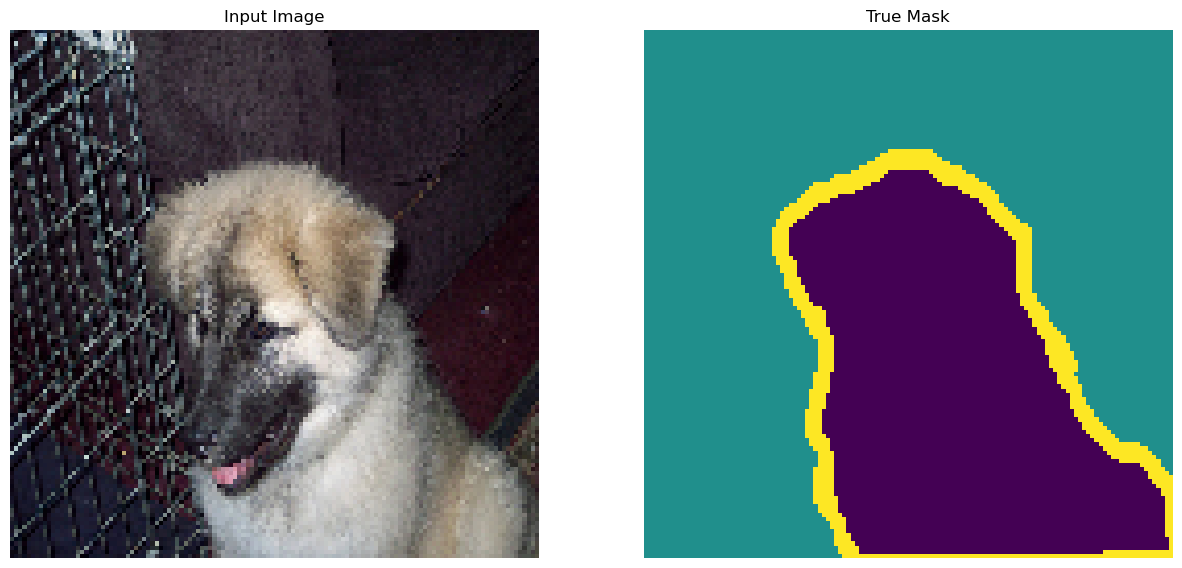

In [10]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [11]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [12]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [13]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [14]:
def build_unet_model():
# inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [15]:
unet_model = build_unet_model()

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

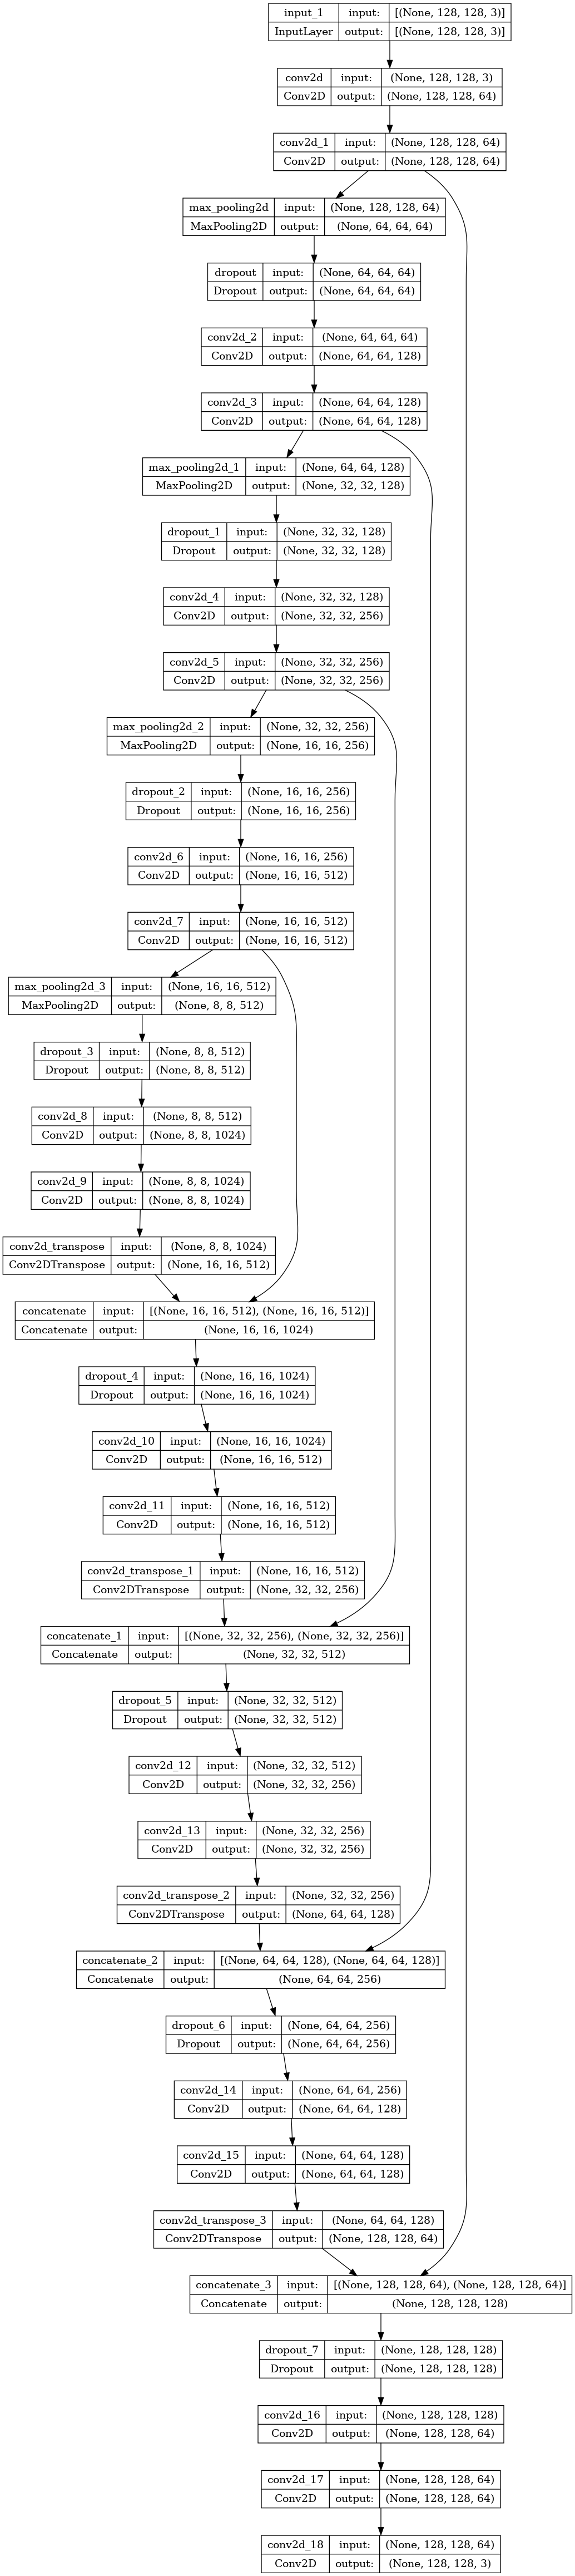

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(unet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [19]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20


2023-08-25 13:47:14.424272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 113s 1s/step - loss: 0.9532 - accuracy: 0.5723 - val_loss: 0.8750 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 87s 1s/step - loss: 0.7921 - accuracy: 0.6636 - val_loss: 0.6758 - val_accuracy: 0.7268
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.6517 - accuracy: 0.7356 - val_loss: 0.6168 - val_accuracy: 0.7518
Epoch 4/20
57/57 [==============================] - 67s 1s/step - loss: 0.6160 - accuracy: 0.7509 - val_loss: 0.5921 - val_accuracy: 0.7619
Epoch 5/20
57/57 [==============================] - 66s 1s/step - loss: 0.5668 - accuracy: 0.7742 - val_loss: 0.5150 - val_accuracy: 0.7975
Epoch 6/20
57/57 [==============================] - 67s 1s/step - loss: 0.5175 - accuracy: 0.7965 - val_loss: 0.4652 - val_accuracy: 0.8165
Epoch 7/20
57/57 [==============================] - 67s 1s/step - loss: 0.4735 - accuracy: 0.8153 - val_loss: 0.4630 - val_accuracy: 0.8190
Epoch 8/20
57/57 [============

In [27]:
test_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [20]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


In [28]:
import numpy as np

# Example: Generating a random pred_mask tensor
batch_size = 64
height = 128
width = 128
num_classes = 20

# Generating random class indices for each pixel
pred_mask_example = np.random.randint(num_classes, size=(batch_size, height, width))

print("Shape of pred_mask_example:", pred_mask_example.shape)

Shape of pred_mask_example: (64, 128, 128)


In [29]:
pred_mask_example[tf.newaxis, ...].shape

(1, 64, 128, 128)

2/2 [==============================] - 0s 189ms/step


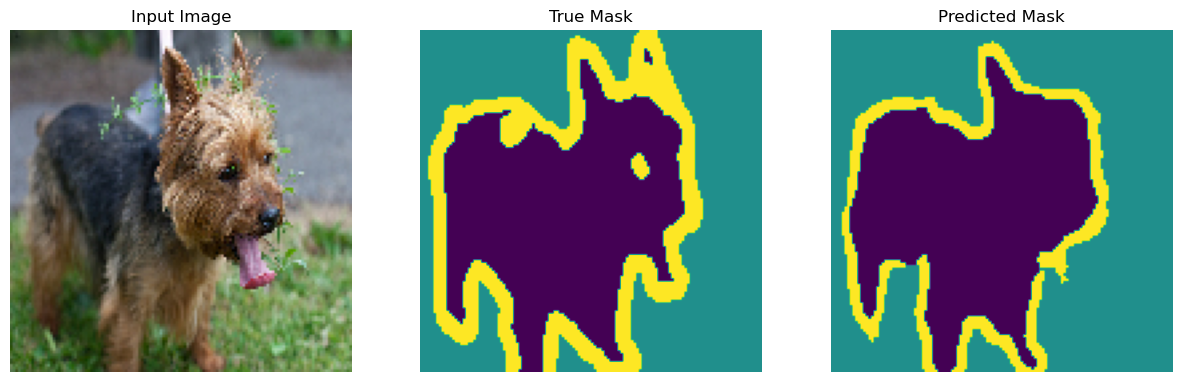

2/2 [==============================] - 0s 115ms/step


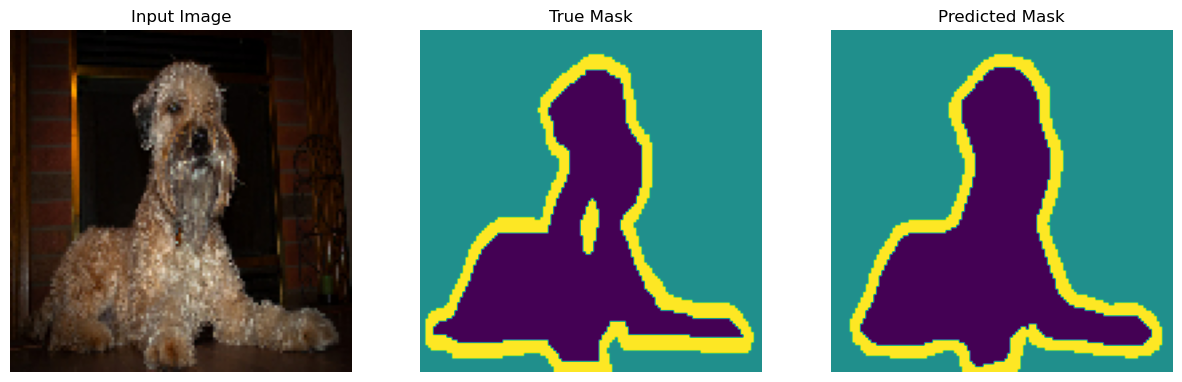

2/2 [==============================] - 0s 114ms/step


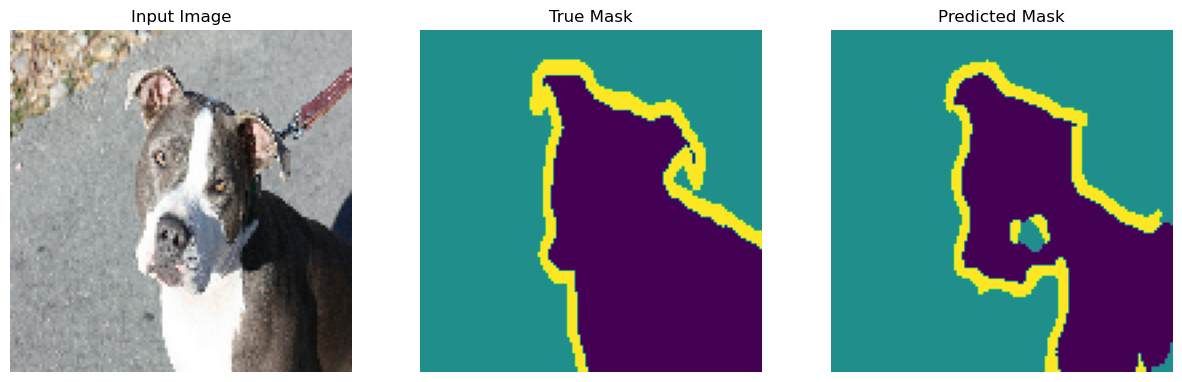

2/2 [==============================] - 0s 113ms/step


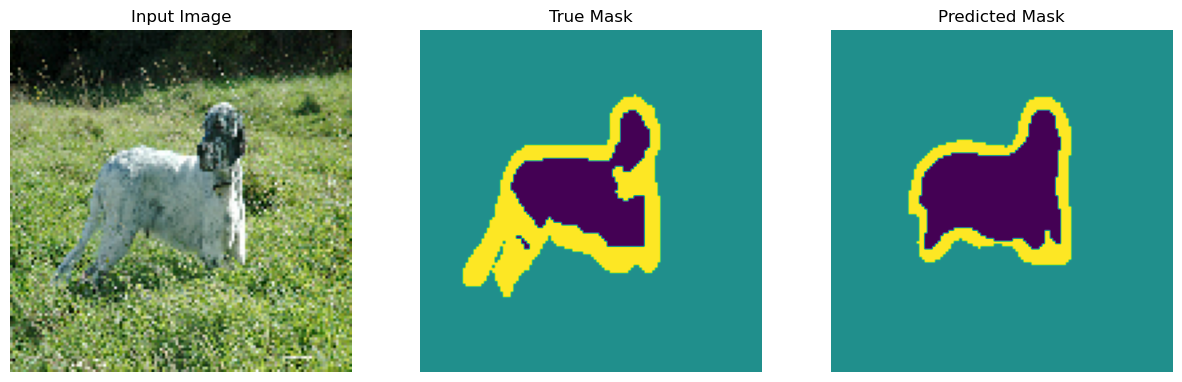

2/2 [==============================] - 0s 111ms/step


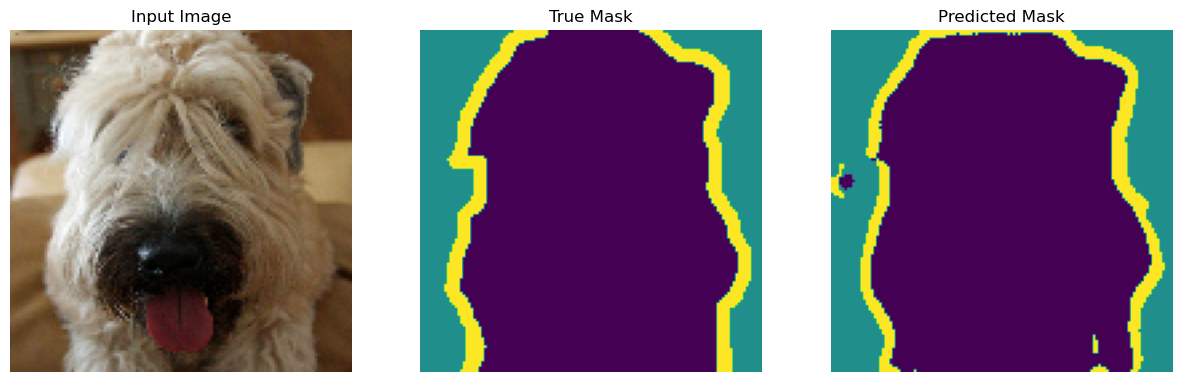

In [23]:
show_predictions(test_batches.skip(5), 5)

testing on images 
dont forget to do the transformation that you have done earlier


### Inference Time

In [48]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

def load_img_from_url(image_url):
    #image_url = "https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_1280.jpg"
    response = requests.get(image_url)
    image_content = BytesIO(response.content)
    image = Image.open(image_content)
    return image

def resize(input_image):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   return input_image

def normalize(input_image):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image

def load_image_infrence(url):
   datapoint = load_img_from_url(url)
   input_image = resize(datapoint)
   input_image = normalize(input_image)
   return input_image

def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(image):
     return image , create_mask(unet_model.predict(image[tf.newaxis, ...]))
    
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()


1/1 [==============================] - 0s 23ms/step


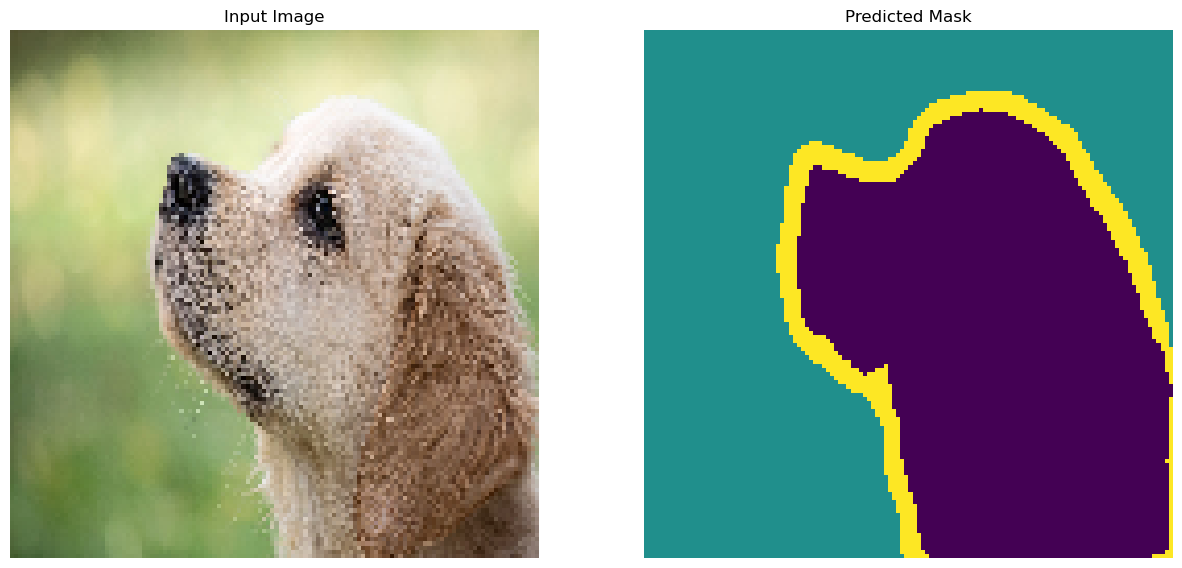

In [49]:
#image = load_image_infrence("https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_1280.jpg")
#https://cdn.pixabay.com/photo/2019/08/07/14/11/dog-4390885_1280.jpg
image = load_image_infrence("https://cdn.pixabay.com/photo/2019/08/07/14/11/dog-4390885_1280.jpg")
image,mask = show_predictions(image)
display([image,mask])

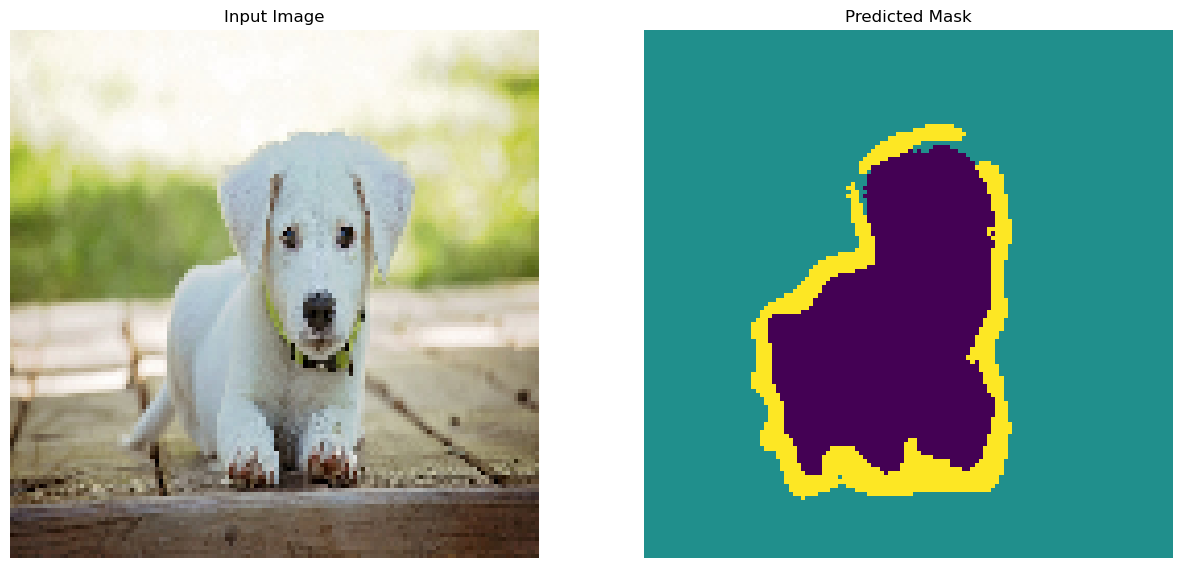